### Extração, Transformação e Carga do conjunto de dados

O arquivo m_3330.csv utilizado neste trabalho foi previamente tratado conforme explicado aqui:
https://github.com/dssantos/alibaba-datacenter-workload/blob/main/extract_transform_load.ipynb

In [39]:
# Transforma o conjunto de dados do arquivo 'machines/m_3330.csv' 
# e faz a carga do resultado no arquivo 'loaded_m_3330.csv'.
import pandas as pd

def dataframe(file):
    df = pd.read_csv(file, 
                 names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                          'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
    df.time_stamp = pd.to_datetime(df.time_stamp, unit='s')
    df.set_index('time_stamp', inplace=True)
    df = df.resample('1min').interpolate()
    #df = df.dropna()
    return df
dataframe('m_3330.csv')

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_3330,17.0,92.0,NaN,NaN,45.21,38.10,3.0
1970-01-01 00:01:00,m_3330,24.0,92.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:02:00,m_3330,16.0,91.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:03:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
1970-01-01 00:04:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_3330,25.0,92.0,5.17,0.0,62.64,55.28,4.0
1970-01-08 23:56:00,m_3330,21.0,90.0,7.04,1.0,62.64,55.28,4.0
1970-01-08 23:57:00,m_3330,26.0,90.0,4.41,0.0,62.65,55.28,4.0


<AxesSubplot:xlabel='time_stamp'>

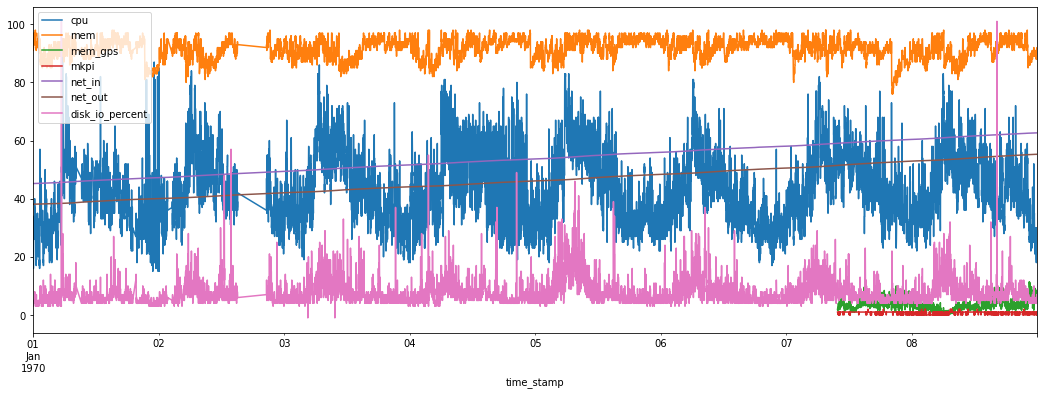

In [40]:
dataframe('m_3330.csv').plot(figsize=(18,6))

### Análise da série temporal

### Treino e teste